In [1]:
%matplotlib inline
import numpy as np

import torch

#seed=1337
#torch.manual_seed(seed)
#torch.cuda.manual_seed_all(seed)

    
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torch.utils.data as data
from torch.autograd import Variable

from torchvision.transforms import Compose, RandomCrop, ToTensor, Scale, RandomHorizontalFlip, CenterCrop, ToPILImage

from PIL import Image, ImageFilter

import os
import sys
sys.path.append('../')

from models.lap_srn import LapSRN
from models.patch_discriminator import PatchD
from loss import CharbonnierLoss, make_vgg16_loss
from skimage.filters import frangi
from skimage.filters import threshold_otsu

import random

In [2]:
from dataset import Dataset, SplitDataset, Split
from torchvision.transforms import Normalize
dataset = Dataset(path='../../data/processed/messidor', 
                  hr_transform=None,
                  lr_transform=None,
                  preload=False)
validation_files = dataset.filenames[int(len(dataset.filenames) * 0.8):]
training_files = dataset.filenames[:int(len(dataset.filenames) * 0.8)]

In [6]:
netD = PatchD(use_sigmoid=True).cuda()
netD.load_state_dict(checkpoint['model_state_discriminator'])
mean=np.array([0.485, 0.456, 0.406])
std=np.array([0.229, 0.224, 0.225])
normalize = Normalize(mean=mean, std=std)
to_tensor = ToTensor()

In [5]:
to_pil = ToPILImage()

model = LapSRN(depth=10).cuda().eval()

continue_training = True # TODO!
if continue_training:
    checkpoint = torch.load('../../best_checkpoints/saly_perc.pt')

    checkpoint = torch.load('../../camp/checkpoints_lossCombination_gan_strong_third/srn_5994.pt')
    model.load_state_dict(checkpoint['model_state'])
    epoch = checkpoint['epoch']

0.9115761675366004 0.9514501329885937 39.751388379316424 42.601966775242694
SR: 0.999985933303833
GT: 0.9987966418266296
BIC: 0.9999809265136719


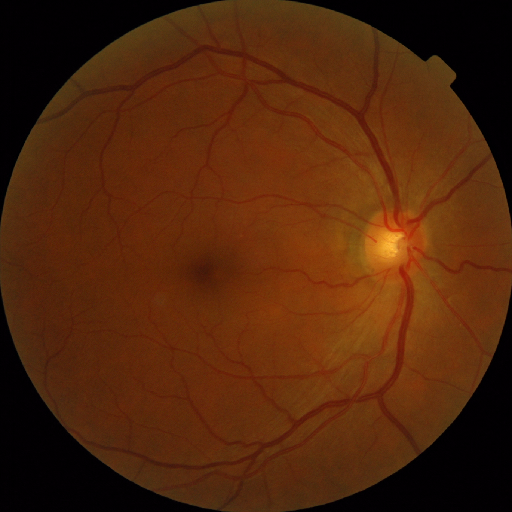

In [10]:
from skimage import measure
from PIL.ImageFilter import GaussianBlur
import PIL.ImageChops as chop
import time
#from dataset import RandomScaling
from validate import vessels, upsample_tensor

    
def upsample_bic(lr):
    lr_size = np.array(lr.size)
    hr2 = lr.resize(2*lr_size, Image.BICUBIC)
    hr4 = lr.resize(4*lr_size, Image.BICUBIC)
    return hr2, hr4

def residual(y, y_hat, transform=lambda x:x):
    y = transform(y)
    y_hat = transform(y_hat)
    return chop.subtract(y, y_hat, scale=0.05)

def acc(y, y_hat, transform=lambda x:x):
    y = np.array(transform(y))
    y_hat = np.array(transform(y_hat))
    total = y.size * 1.0
    correct = ((y == y_hat)*1.0).sum()

    return (correct/total)*100

def mse(y, y_hat, transform=lambda x:x):
    y = np.array(transform(y))
    y_hat = np.array((transform(y_hat)))
    
    diff = y_hat/255.0 - y/255.0
    return np.sum(diff**2)/diff.size    

def psnr(y, y_hat, transform=lambda x:x):
    error = mse(y, y_hat, transform)
    psnr = -10 * np.log10(error)
    return psnr

from PIL import ImageOps
def pad(img, new_size=None, color='black'):
    #print(img.size)
    img = np.array(img).transpose(2,0,1) # Channel first
    size = np.array(img.shape)[1:]
    if new_size is None:
        new_size = np.ceil(size/4) * 4
    diff = new_size - size
    border = np.zeros(4, dtype=np.int)
    border[0] = diff[0]//2
    border[1] = diff[1]//2
    border[2] = diff[0] - border[0]
    border[3] = diff[1] - border[1]

    new_img = np.zeros((3, int(new_size[0]),
                        int(new_size[1])))
    for i,channel in enumerate(img):
        channel_pad = np.pad(channel,
                     ((border[0], border[2]), 
                      (border[1], border[3])),
                     'reflect')
        new_img[i,:,:] = channel_pad
    new_img = np.uint8(new_img).transpose(1,2,0)

    new_img = Image.fromarray(new_img)
    #print(border)
    #print(size, new_img.size)
    return new_img, border

def unpad(img, border, cut_off_stripe=4):
    img = np.array(img)
    new_size = np.array(img.shape[0:-1])
    #print(new_size)
    #bbox = np.array([border[0], border[1], new_size[0] - border[2], new_size[1] - border[3]])
    # Remove additional stripe of 4 px
    border = border + cut_off_stripe
    #print(img.shape)
    #print(border)
    img = img[border[0]:img.shape[0]-border[2],
              border[1]:img.shape[1]-border[3]:,
              :]
    #print(img.shape)
    img = Image.fromarray(img)
    return img

def upscale_with(checkpoint, img, verbose=False, return_p=False):
    model.load_state_dict(checkpoint['model_state'])    

    # Find next largest crop size that is divisible by four.
    crop_size = [int(np.ceil(s/4)*4 + 1) for s in img.size]

    lr_crop_size = [s//4 for s in (crop_size)]
    #print(np.array(lr_crop_size) * 4)
    hr4_gt, border = pad(img)
    #print(lr_crop_size, hr4_gt.size)

    #hr4_gt = center_crop(img)
    lr = hr4_gt.filter(ImageFilter.GaussianBlur(0)).resize(lr_crop_size, Image.BICUBIC)
    #lr_bic = img.resize(lr_crop_size, Image.BICUBIC)
    lr_bic = lr

    elapsed_time, *sr_out = upsample_tensor(model, lr, to_normalize=True, return_time=True)
    hr2_sr, hr4_sr = [unpad(to_pil(out), border) for out in sr_out]
    hr2_bic, hr4_bic = [unpad(out, border) for out in upsample_bic(lr_bic)]
    #hr2_bic, hr4_bic = upsample_bic(lr)

    hr4_gt = unpad(hr4_gt, border)

    #print(img.size, hr4_gt.size, hr4_sr.size, hr4_bic.size)
    if verbose:
        print(measure.compare_ssim(np.array(hr4_gt), np.array(hr4_sr), winsize=255, data_range=256, multichannel=True),\
        measure.compare_ssim(np.array(hr4_gt), np.array(hr4_bic), winsize=255, data_range=256, multichannel=True),\
        measure.compare_psnr(np.array(hr4_gt), np.array(hr4_sr)),\
        measure.compare_psnr(np.array(hr4_gt), np.array(hr4_bic)))

    #residual(hr4_gt, hr4_sr).save('results/residual.jpg')

    inp_sr = Variable(normalize(to_tensor(hr4_sr)).unsqueeze(0).cuda())
    inp_gt = Variable(normalize(to_tensor(hr4_gt)).unsqueeze(0).cuda())
    inp_bic = Variable(normalize(to_tensor(hr4_bic)).unsqueeze(0).cuda())
    p_sr = netD(inp_sr, True).mean().data[0]
    p_gt = netD(inp_gt, True).mean().data[0]
    p_bic = netD(inp_bic, True).mean().data[0]

    if verbose:
        print(f'SR: {p_sr}\nGT: {p_gt}\nBIC: {p_bic}')

    if not return_p:
        return hr4_sr, hr4_gt
    else:
        return hr4_sr, hr4_gt, p_sr

saly_perc = torch.load('../../best_checkpoints/saly_perc.pt')
saly = torch.load('../../best_checkpoints/saliency.pt')
perc = torch.load('../../best_checkpoints/perceptual.pt')
gan = torch.load('../../camp/checkpoints_lossCombination_gan_strong_third/srn_5994.pt')

# RGB:
to_tensor = ToTensor()
to_pil = ToPILImage()#(mode='RGB')
img_path = '../../data/raw/all-images/im0010.ppm'
img_path = '../../data/raw/DRIVE/training/images/23_training.tif'
#img_path = '../../data/processed/eyepacs/25587_right.jpeg'
img_path = random.choice(validation_files)
img_path = '/home/lukas/src/denoisingOphthalmology/data/processed/messidor/20051214_42133_0100_PP.tif'
#img_path = 'frame_full.jpg'
#img_path = 'frame.jpg'

model.eval()
img = Image.open(img_path)
#img.thumbnail([1024, 1024], Image.ANTIALIAS)

crop = RandomCrop(256)
#img = crop(img)

hr4_gan, hr4_gt = upscale_with(gan, img, verbose=True)
hr4_gan.resize((512,512))

0.9407686680014797 0.9514501329885937 41.88618861335981 42.601966775242694
SR: 0.999789297580719
GT: 0.9987966418266296
BIC: 0.9999809265136719


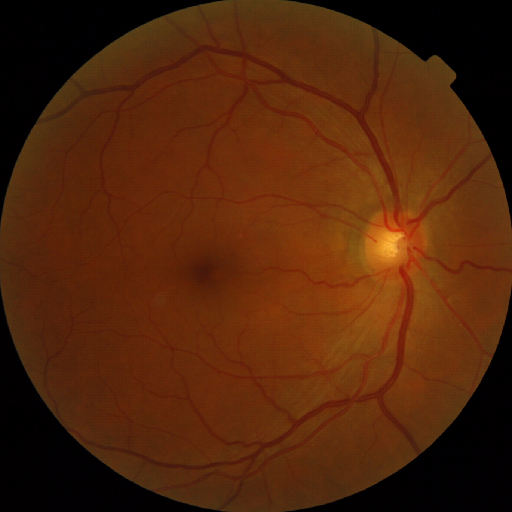

In [15]:
hr4_nogan, _ = upscale_with(saly_perc, img, verbose=True)
hr4_nogan.resize((512,512))

In [16]:
hr4_gan.save('../../results/sr_gan.tif')
hr4_nogan.save('../../results/sr_nogan.tif')
hr4_gt.save('../../results/gt.tif')

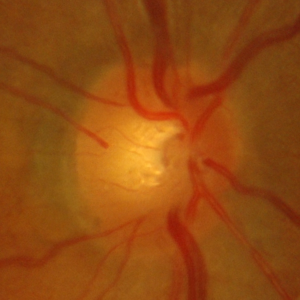

In [20]:
hr4_gan.crop([900,500,1200,800])

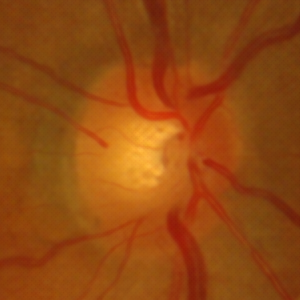

In [21]:
hr4_nogan.crop([900,500,1200,800])

In [26]:
correct = 0
for i in range(100):
    img_path = random.choice(training_files)
    #img_path = 'frame_full.jpg'
    #img_path = 'frame.jpg'

    model.eval()
    img = Image.open(img_path)
    #img.thumbnail([1024, 1024], Image.ANTIALIAS)

    crop = RandomCrop(128)
    img = crop(img).filter(GaussianBlur(1))

    hr4_sr, hr4_gt, p = upscale_with(gan, img, verbose=False, return_p=True)
    if p < 0.1:
        correct += 1
        
correct

64

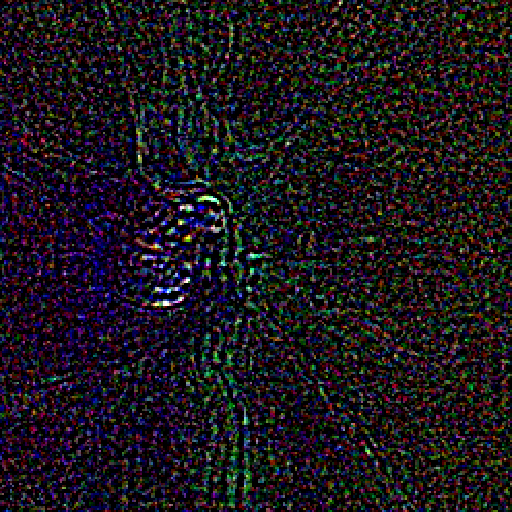

In [110]:
hr_gan, hr4_gt = upscale_with(gan, img)
hr_gan2, hr4_gt = upscale_with(gan2, img)
hr_sal, _ = upscale_with(saly_perc, img)
residual(hr4_gt, hr_gan).resize((512,512))

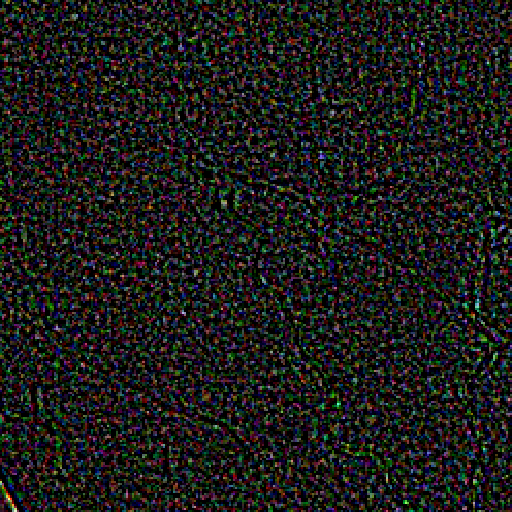

In [63]:
residual(hr4_gt, hr_gan2).resize((512,512))

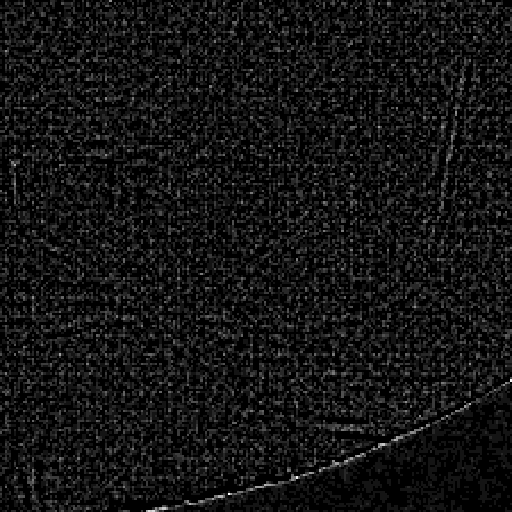

In [12]:
def chop_image(img, num_patches, return_images=True):
    img.crop((0,0,100,100))
    size = np.array(img.size)
    
    size_patch = (np.ceil(size/num_patches)).astype(int)
    size_patch = max(size_patch[0], size_patch[1])
    
    patches = []
    for i in range(num_patches):
        for j in range(num_patches):
            begin = size_patch*np.array([i,j])
            end = size_patch*np.array([i+1,j+1])
            # clip to range
            end = np.minimum(end, size)
            bbox= (begin[0], begin[1], end[0], end[1])
            if return_images:
                patches.append(img.crop(bbox))
            else:
                patches.append(bbox)
    return patches

def residual(y, y_hat, transform=lambda x:x):
    y = transform(y)
    y_hat = transform(y_hat)
    return chop.subtract(y, y_hat, scale=0.05)

from torchvision.transforms import Grayscale
gr = Grayscale()

patches_bic = chop_image(img=hr4_bic, num_patches=4)
patches_sr = chop_image(img=hr4_sr, num_patches=4)
patches_gt = chop_image(img=hr4_gt, num_patches=4)
residual(gr(patches_gt[11]), gr(patches_sr[11])).resize((512,512), Image.NEAREST)
#residual(patches_gt[10], patches_bic[10])
#residual(gr(hr4_gt), gr(hr4_sr))

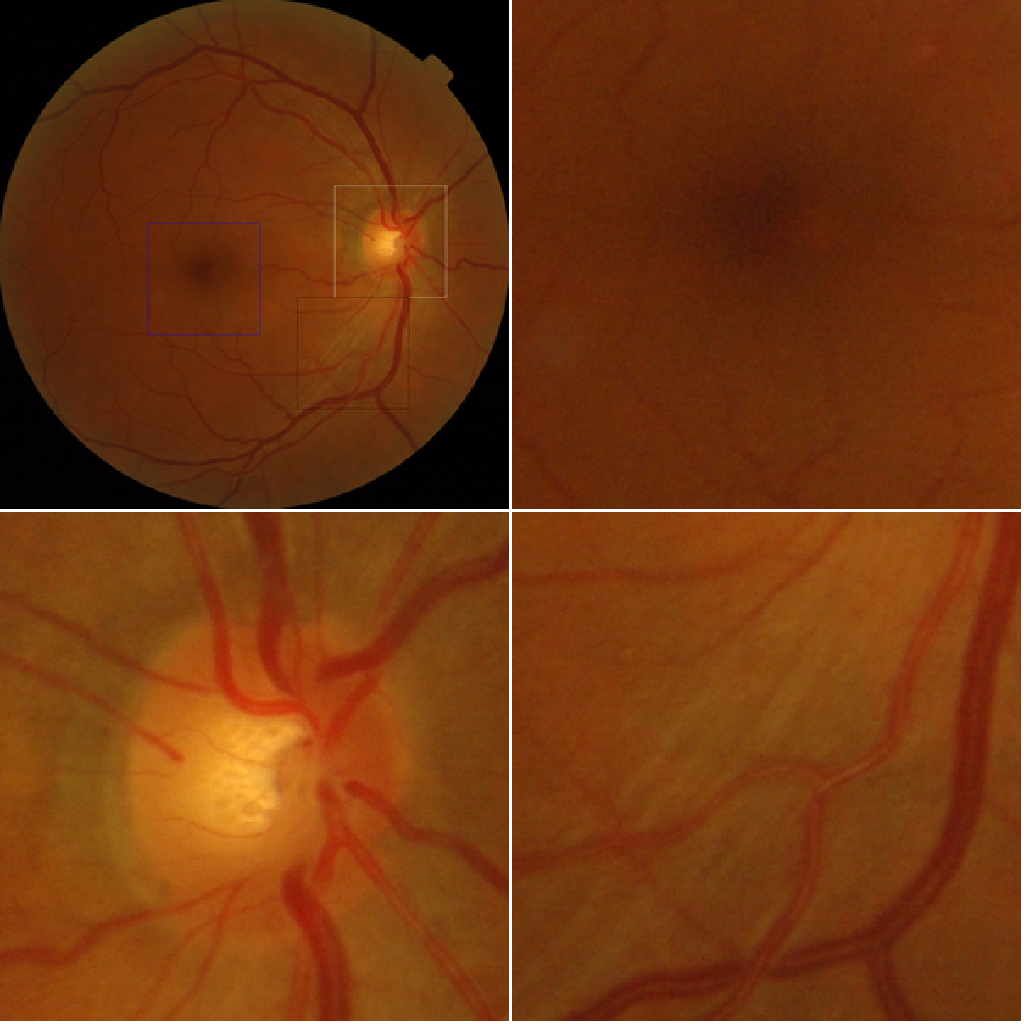

In [34]:
import PIL.ImageDraw as draw
#img_path = '/home/lukas/src/denoisingOphthalmology/data/processed/messidor/20051214_42133_0100_PP.tif'
patches = [[900,500,1200,800],
           [400,600,700,900],
           [800,800,1100,1100]]
i = hr4_gt.copy()
#patches_bic = chop_image(img=hr4_bic, num_patches=4, return_images=False)
#patches_sr = chop_image(img=hr4_sr, num_patches=4, return_images=False)
#patches_gt = chop_image(img=hr4_gt, num_patches=4, return_images=False)
#patches_gt = chop_image(img=residual(hr4_gt, hr4_sr), num_patches=4, return_images=False)

def stitch_collage(img, patches):
    colors = ['white', 'blue', 'black']
    old_img = img.copy()
    drawer = draw.Draw(old_img)

    border_between = 2
    patch_size = patches[0][2] - patches[0][0] 
    compl_size = patch_size + border_between
    new_img = Image.new('RGB', (compl_size*2,compl_size*2),
                        color='white')
    assert(len(patches) == 3)
    for i in range(2):
        for j in range(2):
            idx = i * 2 + j -1
            if idx == -1:
                continue
            # Add crop to collage
            crop = img.crop(patches[idx])
            new_img.paste(crop, (compl_size*i, compl_size*j))
            # Mark collage with border in original image
            drawer.rectangle(patches[idx], outline=colors[idx])
            
    # Make old image square
    new_size = np.array([max(old_img.size[0], old_img.size[1])]*2)
    old_img = pad(old_img, new_size, color='black')[0]
    new_img.paste(old_img.resize((patch_size, patch_size), Image.ANTIALIAS), (0,0))
    return new_img, old_img

#patch_size = patches_gt[0][2] - patches_gt[0][0]
patch_size = 300
#random.shuffle(patches_gt)
stitch_collage(hr4_gt, patches)[0].resize((1024,1024))

In [41]:
img_path = '/home/lukas/src/denoisingOphthalmology/data/processed/messidor/20051214_42133_0100_PP.tif'

img = Image.open(img_path)

hr4_gan, hr4_gt = upscale_with(gan, img)
hr4_sal_perc, _ = upscale_with(saly_perc, img)
hr4_sal, _ = upscale_with(saly, img)
hr4_perc, _ = upscale_with(perc, img)

patches = [[900,500,1200,800],
           [400,600,700,900],
           [800,800,1100,1100]]
stitch_collage(hr4_gt, patches)[0].save('../../results/gt.tif')
stitch_collage(hr4_gan, patches)[0].save('../../results/sr_gan.tif')
stitch_collage(hr4_sal_perc, patches)[0].save('../../results/sr_sal_perc.tif')
stitch_collage(hr4_sal, patches)[0].save('../../results/sr_sal.tif')
stitch_collage(hr4_perc, patches)[0].save('../../results/sr_perc.tif')

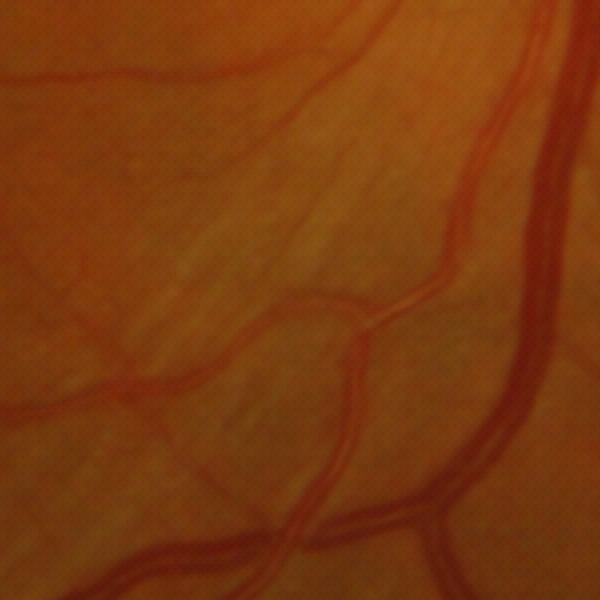

In [33]:
hr4_nogan.crop([800,800,1100,1100]).resize((600,600))

In [75]:
# Drive

from pathlib import Path
drive_dir = Path('../../data/raw/DRIVE/test/') 

num = '03'
mask = Image.open(drive_dir / 'mask/{}_test_mask.gif'.format(num)).convert('YCbCr').split()[0]
img = Image.open(drive_dir / 'images/{}_test.tif'.format(num))
gt = Image.open(drive_dir / '1st_manual/{}_manual1.gif'.format(num)).convert('YCbCr').split()[0]

#crop_size = 140*4
crop_size = [int(np.ceil(s/4)*4) for s in img.size]
#lr_crop_size = [int(np.ceil(s/4)) for s in img.size]#[::-1]
#lr_crop_size = [256//4, 128//4][::-1]
lr_crop_size = [s//4 for s in (crop_size)]
blur_strength = 0

# Center crop has mirrored coordinates.
center_crop = CenterCrop(crop_size[::-1])
#mask = center_crop(mask)
#gt = center_crop(gt)

back_crop = CenterCrop(img.size[::-1])

hr4_gt = img
hr4_blurred = hr4_gt.filter(ImageFilter.GaussianBlur(blur_strength))
lr = hr4_blurred.resize(lr_crop_size, Image.BICUBIC)

elapsed_time, *sr_out = upsample_tensor(model, lr, to_normalize=True, return_time=True)
hr2_sr, hr4_sr = [back_crop(to_pil(out)) for out in sr_out]
hr2_bic, hr4_bic = [back_crop(out) for out in upsample_bic(lr)]

print("GT" ,1000*mse(vessels(hr4_gt, mask).convert('YCbCr').split()[0], gt), sep='\t')
print("Blurred" ,1000*mse(vessels(hr4_blurred, mask).convert('YCbCr').split()[0], gt), sep='\t')
print("SR" ,1000*mse(vessels(hr4_sr, mask).convert('YCbCr').split()[0], gt), sep='\t')
print("BIC" ,1000*mse(vessels(hr4_bic, mask).convert('YCbCr').split()[0], gt), sep='\t')
print("\n\n")

print("GT" , acc(vessels(hr4_gt, mask).convert('YCbCr').split()[0], gt), sep='\t')
print("Blurred" ,acc(vessels(hr4_blurred, mask).convert('YCbCr').split()[0], gt), sep='\t')
print("SR" ,acc(vessels(hr4_sr, mask).convert('YCbCr').split()[0], gt), sep='\t')
print("BIC" ,acc(vessels(hr4_bic, mask).convert('YCbCr').split()[0], gt), sep='\t')
black = Image.fromarray(np.zeros_like(np.array(hr4_gt))).convert('YCbCr').split()[0]
print("Black", acc(black, gt), sep='\t')
print("\n\n")

print("GT" , acc(vessels(hr4_gt, mask).convert('YCbCr').split()[0], (vessels(hr4_gt, mask).convert('YCbCr').split()[0])),
                  sep='\t')
print("Blurred" , acc(vessels(hr4_gt, mask).convert('YCbCr').split()[0], (vessels(hr4_blurred, mask).convert('YCbCr').split()[0])),
                  sep='\t')
print("SR" , acc(vessels(hr4_gt, mask).convert('YCbCr').split()[0], (vessels(hr4_sr, mask).convert('YCbCr').split()[0])),
                  sep='\t')
print("BIC" , acc(vessels(hr4_gt, mask).convert('YCbCr').split()[0], (vessels(hr4_bic, mask).convert('YCbCr').split()[0])),
                  sep='\t')
print("Black", acc(black, vessels(hr4_gt, mask).convert('YCbCr').split()[0]), sep='\t')

chop.multiply(vessels(hr4_sr, mask), hr4_sr)

GT	52.939750272760335
Blurred	52.939750272760335
SR	57.93126439568433
BIC	63.67438477391199



GT	94.70602497272397
Blurred	94.70602497272397
SR	94.20687356043157
BIC	93.63256152260881
Black	90.03121590495817



GT	100.0
Blurred	100.0
SR	97.32846405624925
BIC	96.34379924839375
Black	93.04067159655716


ValueError: image has wrong mode

In [8]:
def pad(img, new_size=None, color='black'):
    img = np.array(img).transpose(2,0,1) # Channel first
    size = np.array(img.shape)[1:]
    if new_size is None:
        new_size = np.ceil(size/4) * 4
    diff = new_size - size
    border = np.zeros(4, dtype=np.int)
    border[0] = diff[0]//2
    border[1] = diff[1]//2
    border[2] = diff[0] - border[0]
    border[3] = diff[1] - border[1]

    new_img = np.zeros((3, int(new_size[0]),
                        int(new_size[1])))
    for i,channel in enumerate(img):
        channel_pad = np.pad(channel,
                     ((border[0], border[2]), 
                      (border[1], border[3])),
                     'reflect')
        new_img[i,:,:] = channel_pad
    new_img = np.uint8(new_img).transpose(1,2,0)

    new_img = Image.fromarray(new_img)
    return new_img, border

def unpad(img, border, cut_off_stripe=4):
    img = np.array(img)
    new_size = np.array(img.shape[0:-1])
    # Remove additional stripe of 4 px
    border = border + cut_off_stripe
    img = img[border[0]:img.shape[0]-border[2],
              border[1]:img.shape[1]-border[3]:,
              :]
    img = Image.fromarray(img)
    return img


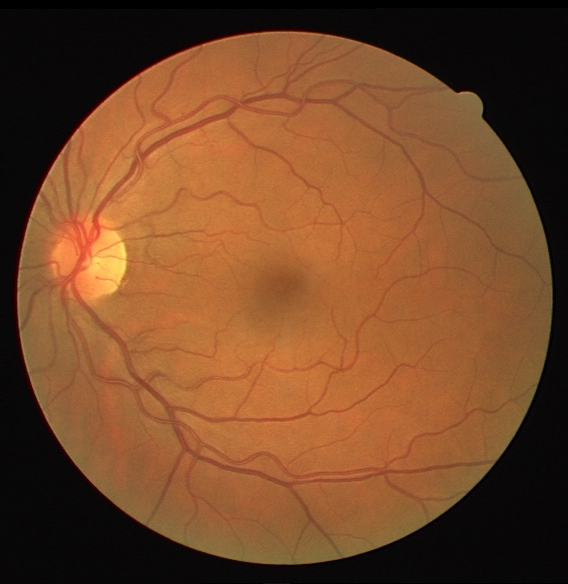

In [10]:
img = Image.open('../../data/raw/DRIVE/test/images/01_test.tif')
new_img, border = pad(img)
new_img

In [11]:
unpad(new_img, border,0).size, img.size

((565, 584), (565, 584))

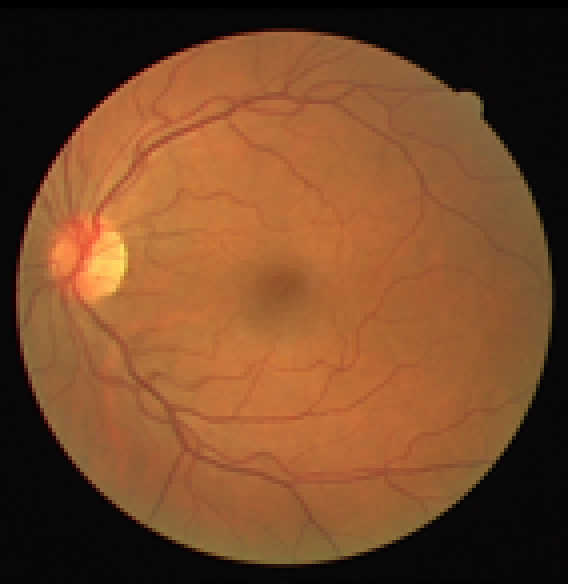

In [17]:
a = new_img.resize((568//4, 584//4), Image.BICUBIC)
a.resize((568, 584), Image.NEAREST)

In [102]:
a = np.array(unpad(new_img, border,0))
b = np.array(img)
np.linalg.norm(a-b)

0.0

In [12]:
new_img.size

(568, 584)

In [372]:
b[0:5,10]

array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0]], dtype=uint8)

In [373]:
np.linalg.norm(a-b)

0.0